In [1]:
from common import *
import mahotas
from scipy import spatial

In [2]:
db = load_db(download_tar("http://vision.lems.brown.edu/sites/default/files/216db.tar.gz"))

216db exists. Skipping


In [3]:
def query(image, descriptor, distance, top_n = 5, db=db):

    C = np.stack([descriptor(im) for im in db.image])

    desc = descriptor(image)
    dists = distance( desc, C )

    
    return db.iloc[np.argsort(dists)].head(n=top_n)


def test_queries(descriptor, distance, top_n=5):

    desc = [descriptor(im) for im in db.image]
    db["desc"]=desc

    queries = []
    results=[]
    for clas in db.clas.unique():
        row = db.query(f"clas=='{clas}'").sample(1).iloc[0]

        C = np.stack(db.desc.to_numpy())

        desc = row.desc
        dists = distance( row.desc, C)

        queries.append(pd.DataFrame(data=[row]))#[["clas","image"]])
        results.append(db.iloc[np.argsort(dists)].head(n=top_n))#[["clas","image"]])
    
    return queries, results

def query_acc(query, result):
    return np.sum(result.clas == query.clas.iloc[0])/len(result)

def query_accuracies(queries, results):
    res = pd.DataFrame()
    for q, r in zip(queries,results):
        res[f"{q.clas.iloc[0]}"]=pd.Series(query_acc(q,r))
    res.index.rename("Accuracy", inplace=True)
    return res


In [4]:
def show_query_results(queries, results):
    qDf = {}
    rDf = pd.DataFrame()
    for i, (q, r) in enumerate(zip(queries, results)):
        qDf[f"{q.clas.iloc[0]}"] = q.image.iloc[0]
        rDf[f"{q.clas.iloc[0]}"] = r.image.reset_index(drop=True)

    print("queries:")
    displayImages(pd.DataFrame(data=[qDf]))
    print("results:")
    displayImages(rDf)

def show_query_accuracy(queries, results):
    print("Accuracies:")
    acc = query_accuracies(queries,results)
    display(acc)
    print(f"Average along classes: {acc.transpose().mean().iloc[0]:.2f}")

In [5]:
def hu_moments(im):
    im = 255*(im==0).astype(np.uint8)
    h=cv2.moments(im)

    return cv2.HuMoments(h).flatten()

def log_transform(vec):
    return -1* np.copysign(1.0, vec) * np.log10(abs(vec))

def hu_moments_log(im):
    hu = hu_moments(im)
    return log_transform(hu)


def l1Dist(vec, dataset):
    return np.linalg.norm( vec.reshape(1,-1) - dataset , axis=-1, ord=1)

def l2Dist(vec, dataset):
    return np.linalg.norm( vec.reshape(1,-1) - dataset , axis=-1, ord=2)

In [6]:
def regularize(image):

    A = np.vstack(np.where(image==0)[::-1])
    center = np.mean(A,axis=-1)
    A = A.T - center
    u, s, vt = np.linalg.svd(A)

    if np.linalg.det(vt) < 0:
        vt[0,:] = vt[0,:]*-1

    r= vt
    c = center
    dsize = (250,250)

    center_d = (dsize[0]/2, dsize[1]/2)
    W = np.zeros((2,3))
    W[:2,:2] = r 
    W[:2,2] = -r@c  + center_d

    im2 = cv2.warpAffine(255-image, W, dsize=dsize)
    return 255 - im2

In [7]:
displayDf(query(db.iloc[6].image, descriptor=hu_moments_log, distance=l2Dist, top_n=5))

,clas,num,image
6,children,06,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAH0AAAB7CAAAAAB8stDkAAACcElEQVRoBcXBQZIkNwDEMPL/j6ZPdoRnq7uU2sMAxi8yfpFxQf4Vf8PYyf/ELWMkf4hLxkgexBVjIs/ihrGQT+KCsZCPYmcs5LOYGQP5ImbGQL6ImTGQL2JmDOSLmBkD+SJmxkC+iJkxkC9iZgzki5gZC/ksZsZCPouZMZGPYmZM5KOYGSP5IGbGSD6ImTGTRzEzZvIkdsZOHsTOmMmT2BkzeRI7YyVP4oIxkkdxwdjIB7EzFvJZzIyFfBYz45x8FyPjnHwXI+OYfBcr45i8iJFxSt7EyDglr2JjnJI3MTJOyavYGKfkVWyMU/IqNsYpeRUb45S8io1xTN7ExjgmL2JkHJM3sTHOyYvYGOfkTUyMc/ImJsYxeRcL45i8i4VxTN7Fwjgm72JhHJN3sTCOyYEYGOfkXQyMc3Igzhnn5F0MjHNyIM4Z5+RAnDPOyYE4ZwzkXZwzBnIgjhkDORDHjIUciFPGQg7EKWMhB+KUsZADccqYyLs4ZSzkXRwzFvIujhkDeRfnjIW8iYExkRcxMDbyXQyMjbyIc8ZIvoqBMZJvYmGM5LPYGCv5KDbGTD6IkbGTZzEybsij2BhX5ElsjCvyJDbGFXkSG+OKPImNcUWexMa4Ig9iZNyQJzEybsiDWBk35EGsjAvyJFbGBXkSK+OCPImVcUEexMy4IA9iZlyQBzEzLsiDmBkX5E+xMy7In2Jn3JCf4oJxQ36KC8YV+SEuGFfk/+KGcUV+iAvGHfkhdsYd+UOsjCvyJDbGFfkgBsYV+STOGTfkszhm3JDP4phxQz6Kc8YV+SAGxh15EhPjmvwQI+OvyH9iZvwi4xf9A1KX8gFcWkEVAAAAAElFTkSuQmCC"" width=""100"" >"
17,children,07,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAH4AAAB7CAAAAACXhWvnAAACcElEQVRoBcXBQZIkNwDEMPL/j6ZPDsfOVHcp5cMCxt9k/E3GBflX/C/GTP4U14yR/BK3jJE8iDvGRJ7FFWMiH8QNYyEfxQVjIZ/FzhjIF7EzBvJF7IyBfBMzYyDfxMwYyDcxMwbyReyMgXwRO2Mg38TMWMhnsTMW8lnsjIl8FDtjIx/FzNjIJ7EzVvJBzIyZPIqdsZMHccGYyZO4YMzkSVwwZvIgbhgreRQXjJE8ihvGRj6IC8ZCPoudsZAvYmYM5JuYGefku1gZx+RFrIxj8iJWxil5EyvjlLyKkXFK3sTKOCWvYmScklcxMk7Ju9gYp+RVjIxT8ipGxjF5EyPjmLyIlXFM3sTIOCcvYmSckzexMc7Jm9gY5+RVTIxj8i4mxjE5EAvjmLyLiXFMDsTCOCfvYmGck3exMM7JgRgY5+RADIyBvIuBcU5OxDljIO9iYAzkQJwzBnIgzhkLeRfnjIUciGPGQg7EMWMhJ+KUMZEDccpYyIk4ZUzkXRwzFvIuzhkLeRUDYyJvYmBM5EUsjI18FwtjJN/FwBjJV7EwRvJNTIyVfBYbYyUfxciYyQexMnbyQYyMG/IoRsYVeRIj44o8io1xRZ7EyLgiT2JkXJEnMTKuyJMYGVfkQayMG/IkVsYNeRAz44I8iZlxQZ7EzNjJo5gZO3kUM+OCPIidcUEexM64IA9iZ1yQB7EzbsgvccG4Ib/EBeOG/BQ3jCvyU1wwrsgPccO4I3+KG8Yd+SEuGHfkl5gZd+S3WBlX5FlMjCvyUZwzbshncc64IZ/FOeOGfBQD44p8EAvjjjyJjXHL5E+xMv4X+U/MjL/J+Jv+AZak8wG7Qn4AAAAAAElFTkSuQmCC"" width=""100"" >"
40,children,10,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAH8AAAB7CAAAAAB4RwDZAAACcElEQVRoBcXBQZIkNwDEMPL/j6ZPdoRnqruU2sMCxl9l/FXGDflX/BFjJ/8T94yV/BK3jJE8iTvGRp7FFWMin8QNYyIfxQVjIZ/FBWMhX8TOGMg3sTMG8k3sjIF8EztjIN/EzhjIN7EzFvJF7IyFfBE7YyGfxQVjIp/FzpjIZ7EzNvJR7IyVfBA7YyUfxM6YyaO4YOzkSVwwdvIkLhg7eRA3jJk8iRvGTJ7EDWMkz+KGMZIP4oIxkY/igrGQL2JnDOSrmBnn5LuYGefkRayMY/ImVsYxeRMr45S8ipVxSl7Fyjgmr2JkHJNXMTKOyasYGcfkVYyMY/IqRsYxeRMr45y8iZFxTl7Eyjgnb2JkDORFjIyBvImNcU7excQYyKuYGAN5FRPjnLyLiTGQd7EwzsmBWBgDeRcLYyDvYmEM5EAMjIW8i4GxkHcxMBZyIM4ZCzkQ54yJvItzxkQOxDFjIgfimDGRE3HKmMiJOGVM5EScMiZyIk4ZG3kXx4yNvIpzxkbexMDYyItYGCP5KibGSL6LhTGS72JhrOSrWBgr+SYmxko+i5Exk09iZczkk1gZO/kgVsYNeRYj44o8iZVxRR7FyLgij2JkXJFHMTKuyJNYGVfkSayMK/IgZsYNeRIz44Y8iJ1xQx7EzrggT2JnXJAnsTN28ih2xgV5EjvjgjyIC8YFeRAXjBvyW1wwbshvccG4Ib/EDeOG/BI3jCvyQ1wxrshPccO4Ij/EFeOO/BA3jDvyS+yMK/IgZsYVeRQj44Z8FgPjhnwWA+OKfBbnjBvyRZwzrshncc64Ix/Ewrhl8kOsjD8i/4kLxl9l/FX/APKP8wFYPPQuAAAAAElFTkSuQmCC"" width=""100"" >"
214,children,14,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAH8AAAB8CAAAAABlQjBhAAACdUlEQVRoBcXBMYLYNhDAQOD/j0ZSubiTRO668IzxTxn/lLEh/4u/ZyzIHxl/wZiSn2LNGJLfYsuYkUexY4zIi1gxJuRVbBgT8i4WjAH5EAvGgHyJOWNAPsSCMSBfYs64J19iwRiQLzFnDMiHWDAG5EvMGRPyLhaMCXkXC8aEvIsFY0RexYIxI69izhiSF7FgTMmzWDCm5FksGGPyJDaMMXkSG8aYPIkNY0yexIYxJI9ixRiSZ7FhjMib2DAm5F0sGAPyJeaMAfkSc8Y9+RZjxj35FmPGNTmIMeOWnMSYcUuOYsq4JUcxZdySo5gyrslRDBnX5CSmjGtyFEPGNTmJKeOanMSUcU8OYsq4JwcxZdyTg5gyBuQghowBOYgh454cxYwxICcxYwzIUYwY9+QsRowBOYoRY0COYsSYkKOYMCbkKCaMCTmLAWNCzmLAGJGjGDBG5CzuGSNyFveMETmLe8aE3IhrxohciGvGhFyJW8aI3IhbxoRciVvGiFyIa8aIXIhrxogcxYAxIicxYczItxgxZuRbjBhD8ilGjCH5FhPGkHyKEWNIvsSMMSWvYsqYkjcxZozJs5gz5uRRzBkL8ijGjA15EmPGijyIMWNDnsSYsSEPYs5Ykd9iztiQBzFnbMhvsWAsyINYMObkQWwYC/JbbBhz8iA2jDl5EBvGnDyJBWNOHsSGMScPYsOYk99ixZiTB7FhzMlvsWIsyC+xYizIT7FjbMgPsWNsyA+xY2zID7FjbMhPsWKsyE+xYWzIg5gzNuRRTBkL8ipGjAV5FxPGgnyIAWNBPsSAsSGvYsJYkRcxYiyZ/BBjxt+QP2LD+KeMf+o/XcL2ARUGdOUAAAAASUVORK5CYII="" width=""100"" >"
199,children,11,"<img src=""data:image/png;base64, iVBORw0KGgoAA

In [8]:
queries, results = test_queries(hu_moments, l1Dist, top_n=5)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABVCAAAAABf3YQRAAAC9klEQVRoBb3BiWHiQADAQKn/onVr42chkBAgN2P8d8Z/Z/x3xi8ZbzJ+QxbxFuMJZnKIifFLxo/kjgSSXRLPMX4gvxBPML4nvxQ/Mb4lL4hvGd+RV8VDxjfkLXGX8Q15T9xjPCbviy+Mx+QD4pbxkHxE3DAeks+Ia8Yj8ilxxXhEPiWuGI/Ix8TMeEQ+JmbGA/JBMTEekE+Kk/GAfFKcjPvks+JggBk35LPiYIAMcUU+LHYGsoqJfFrsDJBFnOTjYmeALOIknxcbYyEQJ/m82BgrgdjJH4iNsRKIjfyJuDBWArGRPxEXxkogNvIn4sJYyBAb+RNxYSxkiAv5G3FhLARiI38kVsYgQ2zkjkDeFCtjEIidfBGDvClWxiBDbORaXMibYmUMArGTK7GRNyTEygBZxEZ2CbGTNyTEyhgEYiOHJE7yshBiZQwyxIVsAomDvC4QYmEMMsRKdoFxktcFQiyMQS6SU9yQ1wUSK2MhX8QteVmAEAtjIV/EDXldgBALYyU34pa8LkCIhbGRWXwhL4uFEINxMrmIL+QNMQgxGDNZxR3yslgIMRgzQyC+ku+FPBIricG4IXGPTJJrAfJAXAgBxjWJu2QSyJVAHoiNBBhPkkkgswA5JLO4kADjSXKKQSYxyC5kEhdCYDxLDjHIJEB2AXKKmfEkOcUgkxhkFyCHmBlPklMs5BSDbGKQU0yM58gpVnKKQTaxkENMjOfIKVZyikE2sZBDTIznyCEu5BSDbGIlu5gYz5FDXMgpBtnESg5xMp4ju9jJIQbZxEoOcTKeI7vYySEG2cRKTnEwniO72MkuBjnESnZxMp4iuzjILhayiZWc4mA8Qw5xkF0MsouFnOJk/EwmcZBdDHIIkEmcjB/JJCayiUF2McgkTsZPZBYT2QXIJgaZxcn4gVyJiezilkxiYvxEJjGRQ3whu7hi/EgOcZJJ3GECccN4ikBckUk8z3iRzOJ5xqvkFL9gvEpO8QvGy2QTv2K8w4zfMv47478z/rt/WxorEMqsV+UAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABkCAAAAACQ+1AZAAACZklEQVRoBb3BiWHiQADAQKn/onUhmH9N7MXHjPF1xtcZX2ccwdjO+Jz8iK2MWYbJk/iTMcVkVbxlTJD3MtYZu8kWscbYRzaLMWMX2SNGjD1klxgxtpO9YsDYTvaLF8ZWMiNeGBvJnIxHxjbymbgyNpEPxZWxhXwsLowN5GNxZfxJDhAIBBh/kuMEGH+R42RgvCcHihPjPTlQnBhvyYHil/GOHCjOjHfkOLEw1smh4sxYJ8eKX8YqOVacGavkWHFmrJGDxZmxRo4VC2OFHCsujDVypLgyVsih4spYIUeKG2OFHCjuGGNypLhjjMmh4sYYk2PFlTEkR4sLY0yOFgtjSI4XZ8aQHC/OjCE5XpwZQ3KA5F6cGUPyuZA7sTCG5FMBcicWxoh8Kn7ITVwYI/KZOJGbuDJG5CNxIjdxY4zIB+JMruKOMSAfiIUs4oExIPNiIYt4ZAzItLgQCIknxiuZFjdCSDwxXsmsuCMxYrySSbGF8UImxSbGC5kT2xivZEZsZLySCbGV8UymxFbGM5kQ2xmPZEpsZzyQGbGHcUemxC7GjcyJXYwbmRB7GRcyIfYzLmS/mGAsZK+YY5zJPjHNOJN9YpqxkF1imnEmf0gexCzjl6xKIEAexRzjRNbFhTyKKcaJrIsLeRIzjB+yKu7Ik5hg/JBVcU8exQQDZFU8kQexnwGyJp7JvZhggKyJF3Iv9jNAhmJIbmKCATISY3ITEwyQkRiTi5higLyKFXIVU4wf8ixWyVlMMk7kUaySRUwyfsm9eENOYprxS+7EW5Ixz1jIIv4zYyG/4r8zHhj/nfF1xtcZX/cP5bLqAWNiAEYAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAA0CAAAAACcdVjuAAABT0lEQVRYCb3BB2KjAADAMPv/j/a1EFYz4QKScTnjcsbljC8yMzMzMx4w/o/JW7FmHGFIskNMjH0kOSBmxufkP8TE+JwcFzNjDzkqZsYOcljMjD3kqJgZO8hhMTM+J4fFwnhE4p4cFzPjESH+MDkuZsYjQpIkSfIjOSwWxgPybbEw7snXxcK4JyeJX8aWnCcGxoacKAbGhpwoBsbC5EwxMGZyshgYN3K6GBgjOV8MjJGcLwbGSM4XA2MiZ4uBcSOni4ExkksEGAgh1wgMkMsEGCCXCTBArhBCgIFcISbGQE4XN8ZIjkrei4Uxko/EA/JOrBgjeSfjMVkL5I9YMW7ktXhOVgLZijXjRl6L52QRIFuxZsxkkWzFSzKKgazFhjGTSSBb8YZATGQRW8aa/IofshJ7yST+MJ6RRewnv+KO8ZRM4puMF8yMLzMuZ1zOuNw/NtGOAeszs6kAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA8CAAAAACS+sH6AAABV0lEQVRYCb3BB2LiQADAQOn/j9YZU45iJ2A2O2PMZ8xnzGfMZ+wwIWM8Y4esYjxjm1zEcMYmuYnRjC1yL8YyNsiDGMt4JU9iKOOFbIhxjGeyJ2ME44n8JAYw7sk74jvGHXlP/M6QkJPMjDPjjrwpnphh3MirODOu5H3JEbEyLmSCODHOZIY4MVYyRyyMhUwTYCxkmgBjIbPEwljIJHFiLGSOWBkLmSLOjBOZIC6MhfyxhLgyFvKn4pGxkK+EEAu5E3IST4yFHJXEibGSqwDJeGYs5KA4wljIQXGEcSIfCyGOMFbyqZA4xDiTz8RxxpV8Io4zbuRd8RXjP3lTfMV4IL+I7xmP5AcZAxiPZFcMYryQTTGK8Uo2xDDGBnkWAxkb5FkMZGySBzGSsU0exEDGDrmJsYw9chGDGbtkFaMZ+2QVgxm7ZBWjGftkEcMZ8xnzGfMZ8xnz/QN3wIkBHkImZAAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABaCAAAAACuizbEAAACF0lEQVRoBb3BCWLbMADAMPL/j+bSrUlz+JBtrYDx64xfZ/w6Y5kZ/4fxSb7F/2B8kB8xn/FOnsV0xht5FbMZL+RDTGb8JWSyJOYyvsiGmMsA2RRzGSDbYioD2RFTGf9IgCyKmYwXsiCmMl7IgpjKeCELYirjhSyIqYxnsiDmMl7Ih5jMeCafYjLjiSyJuYwnsiTmMn7IipjJeJBVMZHxIBtiGuNBNsUkxp1si0mMO9kTUxh3si8mML7JkLjMuJMxcZHxTUbFNcadDIsrjG9yRJxn3MkhcZZxJ8fEScadHBTnGA9yVJxhPMhxcZzxICfEYcYPOSGOMp7IGXGM8UTOiSOMF3JKHGC8kJNimPFGzolRxhs5K8YYH+SkGGJ8kNNigLFAzop9xhI5LfYYi+S82GYskwtii7FCLogNxiq5IFYZ6+SCWGNskStikbFJrolPxg65Jt4Zu+SaeGUMkGvimTFELoknxiC5Ju6MUfJXfJHj4h9jlHyJH3JU3BjD5CbeyQEBxjC5iUUmIwKMUfIlVsm+AGOY3

results:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABVCAAAAABf3YQRAAAC9klEQVRoBb3BiWHiQADAQKn/onVr42chkBAgN2P8d8Z/Z/x3xi8ZbzJ+QxbxFuMJZnKIifFLxo/kjgSSXRLPMX4gvxBPML4nvxQ/Mb4lL4hvGd+RV8VDxjfkLXGX8Q15T9xjPCbviy+Mx+QD4pbxkHxE3DAeks+Ia8Yj8ilxxXhEPiWuGI/Ix8TMeEQ+JmbGA/JBMTEekE+Kk/GAfFKcjPvks+JggBk35LPiYIAMcUU+LHYGsoqJfFrsDJBFnOTjYmeALOIknxcbYyEQJ/m82BgrgdjJH4iNsRKIjfyJuDBWArGRPxEXxkogNvIn4sJYyBAb+RNxYSxkiAv5G3FhLARiI38kVsYgQ2zkjkDeFCtjEIidfBGDvClWxiBDbORaXMibYmUMArGTK7GRNyTEygBZxEZ2CbGTNyTEyhgEYiOHJE7yshBiZQwyxIVsAomDvC4QYmEMMsRKdoFxktcFQiyMQS6SU9yQ1wUSK2MhX8QteVmAEAtjIV/EDXldgBALYyU34pa8LkCIhbGRWXwhL4uFEINxMrmIL+QNMQgxGDNZxR3yslgIMRgzQyC+ku+FPBIricG4IXGPTJJrAfJAXAgBxjWJu2QSyJVAHoiNBBhPkkkgswA5JLO4kADjSXKKQSYxyC5kEhdCYDxLDjHIJEB2AXKKmfEkOcUgkxhkFyCHmBlPklMs5BSDbGKQU0yM58gpVnKKQTaxkENMjOfIKVZyikE2sZBDTIznyCEu5BSDbGIlu5gYz5FDXMgpBtnESg5xMp4ju9jJIQbZxEoOcTKeI7vYySEG2cRKTnEwniO72MkuBjnESnZxMp4iuzjILhayiZWc4mA8Qw5xkF0MsouFnOJk/EwmcZBdDHIIkEmcjB/JJCayiUF2McgkTsZPZBYT2QXIJgaZxcn4gVyJiezilkxiYvxEJjGRQ3whu7hi/EgOcZJJ3GECccN4ikBckUk8z3iRzOJ5xqvkFL9gvEpO8QvGy2QTv2K8w4zfMv47478z/rt/WxorEMqsV+UAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABkCAAAAACQ+1AZAAACZklEQVRoBb3BiWHiQADAQKn/onUhmH9N7MXHjPF1xtcZX2ccwdjO+Jz8iK2MWYbJk/iTMcVkVbxlTJD3MtYZu8kWscbYRzaLMWMX2SNGjD1klxgxtpO9YsDYTvaLF8ZWMiNeGBvJnIxHxjbymbgyNpEPxZWxhXwsLowN5GNxZfxJDhAIBBh/kuMEGH+R42RgvCcHihPjPTlQnBhvyYHil/GOHCjOjHfkOLEw1smh4sxYJ8eKX8YqOVacGavkWHFmrJGDxZmxRo4VC2OFHCsujDVypLgyVsih4spYIUeKG2OFHCjuGGNypLhjjMmh4sYYk2PFlTEkR4sLY0yOFgtjSI4XZ8aQHC/OjCE5XpwZQ3KA5F6cGUPyuZA7sTCG5FMBcicWxoh8Kn7ITVwYI/KZOJGbuDJG5CNxIjdxY4zIB+JMruKOMSAfiIUs4oExIPNiIYt4ZAzItLgQCIknxiuZFjdCSDwxXsmsuCMxYrySSbGF8UImxSbGC5kT2xivZEZsZLySCbGV8UymxFbGM5kQ2xmPZEpsZzyQGbGHcUemxC7GjcyJXYwbmRB7GRcyIfYzLmS/mGAsZK+YY5zJPjHNOJN9YpqxkF1imnEmf0gexCzjl6xKIEAexRzjRNbFhTyKKcaJrIsLeRIzjB+yKu7Ik5hg/JBVcU8exQQDZFU8kQexnwGyJp7JvZhggKyJF3Iv9jNAhmJIbmKCATISY3ITEwyQkRiTi5higLyKFXIVU4wf8ixWyVlMMk7kUaySRUwyfsm9eENOYprxS+7EW5Ixz1jIIv4zYyG/4r8zHhj/nfF1xtcZX/cP5bLqAWNiAEYAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAA0CAAAAACcdVjuAAABT0lEQVRYCb3BB2KjAADAMPv/j/a1EFYz4QKScTnjcsbljC8yMzMzMx4w/o/JW7FmHGFIskNMjH0kOSBmxufkP8TE+JwcFzNjDzkqZsYOcljMjD3kqJgZO8hhMTM+J4fFwnhE4p4cFzPjESH+MDkuZsYjQpIkSfIjOSwWxgPybbEw7snXxcK4JyeJX8aWnCcGxoacKAbGhpwoBsbC5EwxMGZyshgYN3K6GBgjOV8MjJGcLwbGSM4XA2MiZ4uBcSOni4ExkksEGAgh1wgMkMsEGCCXCTBArhBCgIFcISbGQE4XN8ZIjkrei4Uxko/EA/JOrBgjeSfjMVkL5I9YMW7ktXhOVgLZijXjRl6L52QRIFuxZsxkkWzFSzKKgazFhjGTSSBb8YZATGQRW8aa/IofshJ7yST+MJ6RRewnv+KO8ZRM4puMF8yMLzMuZ1zOuNw/NtGOAeszs6kAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA8CAAAAACS+sH6AAABV0lEQVRYCb3BB2LiQADAQOn/j9YZU45iJ2A2O2PMZ8xnzGfMZ+wwIWM8Y4esYjxjm1zEcMYmuYnRjC1yL8YyNsiDGMt4JU9iKOOFbIhxjGeyJ2ME44n8JAYw7sk74jvGHXlP/M6QkJPMjDPjjrwpnphh3MirODOu5H3JEbEyLmSCODHOZIY4MVYyRyyMhUwTYCxkmgBjIbPEwljIJHFiLGSOWBkLmSLOjBOZIC6MhfyxhLgyFvKn4pGxkK+EEAu5E3IST4yFHJXEibGSqwDJeGYs5KA4wljIQXGEcSIfCyGOMFbyqZA4xDiTz8RxxpV8Io4zbuRd8RXjP3lTfMV4IL+I7xmP5AcZAxiPZFcMYryQTTGK8Uo2xDDGBnkWAxkb5FkMZGySBzGSsU0exEDGDrmJsYw9chGDGbtkFaMZ+2QVgxm7ZBWjGftkEcMZ8xnzGfMZ8xnz/QN3wIkBHkImZAAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABaCAAAAACuizbEAAACF0lEQVRoBb3BCWLbMADAMPL/j+bSrUlz+JBtrYDx64xfZ/w6Y5kZ/4fxSb7F/2B8kB8xn/FOnsV0xht5FbMZL+RDTGb8JWSyJOYyvsiGmMsA2RRzGSDbYioD2RFTGf9IgCyKmYwXsiCmMl7IgpjKeCELYirjhSyIqYxnsiDmMl7Ih5jMeCafYjLjiSyJuYwnsiTmMn7IipjJeJBVMZHxIBtiGuNBNsUkxp1si0mMO9kTUxh3si8mML7JkLjMuJMxcZHxTUbFNcadDIsrjG9yRJxn3MkhcZZxJ8fEScadHBTnGA9yVJxhPMhxcZzxICfEYcYPOSGOMp7IGXGM8UTOiSOMF3JKHGC8kJNimPFGzolRxhs5K8YYH+SkGGJ8kNNigLFAzop9xhI5LfYYi+S82GYskwtii7FCLogNxiq5IFYZ6+SCWGNskStikbFJrolPxg65Jt4Zu+SaeGUMkGvimTFELoknxiC5Ju6MUfJXfJHj4h9jlHyJH3JU3BjD5CbeyQEBxjC5iUUmIwKMUfIlVsm+AGOY3

Accuracies:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
Accuracy,,,,,,,,,,,,,,,,,,
0,0.4,0.2,1.0,0.4,0.2,0.6,0.6,0.2,0.2,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.8,0.8


Average along classes: 0.46


In [9]:
queries, results = test_queries(hu_moments_log, l1Dist, top_n=5)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABWCAAAAADZSfa/AAAC50lEQVRoBb3BCWKiAADAwOT/j86CcluPItsZ488Zf874c8aXzMz4mPEF2YmPGCeZPIr3jHPkiXjHOENeiNeME+SleMl4T2JD3ooXjDdkFmbyiXjOeE1OimeMl+S0eMJ4Qb4SPzKek+/Ej4zn5FvxA+Mp+V48Mp6S78Uj4xm5QjwwnpILxAPjGblEHBlPyDXiyHhCLhIHxhNykTgwfiaXiT3jCblK7Bk/k+vEjnEjsSMXii0DZBBbcqXYMpBRbMmlYsMAGcSGXCs2DJBRrORasWGAjGIhV4uVcSMQM7larIyRDGIi14uFcSMQE7lcrIwbgbiT/yAWxo1A3Ml/EAtjJBAT+Q9iYYwEYiL/QSyMgQxiIkcZ8pVYGAOBmMlO3Mk3YmEMZBAT2YqJfCVmxkAgJrJIYiJfiYUxkEHcySyJhZyVQMwMkEFMZBZbclZCLIyBDOJGZrEjZyXEwhjIIG5kEntyVggxMwZyk8ksDuSkQIiZMZBHcSAnBQgxMUZyFAdyVgyEuDNuZC+O5KS4EYiRcSdb8UBOijshRsaGTOJIzoqJQICxJSHEAzkrZkKAcSDEI3kpeSJWEmDsCfED2Uh2AuRnsRICY8/4kawC2QqQn8WGBMZnZBXIVoDMQlZxZHxGVgGyEQOZhGzEgfEZWcRANgJkFsgqDoyPyCpGsgqQWYAs4sD4jCxiJIsYyV2MZBYHxmdkFjeyCpBZDGQRe8ZHZBF3soiBTGIks9gzPiKzuJNFDGQWI5nFnvERmcVEZjGQSdzIInaMj8gsJjILkEWMZBE7xkdkEjOZhaziTmaxY3xEJjGTWcgq7mQWO8YHZBEzmSUbcSOL2DHek0UsZBayiBtZxY7xjmzESiYhixjJRuwYb8hWrGQSMouRbMWO8YZsxJZM4kA2Ys94TbZiJYs4kkUcGG/IKlayikcyikfGB2QUG7KKXzFOka34DeMcWcWvGOfIKn7FOEkm8UvGeWb8nvHnjD9n/Ll/66AmEKmoSHgAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABRCAAAAADETMYHAAABzElEQVRoBb3BCYLaMADAQOn/j1a5yrUEHOIwY/yc8XPGzxkbmLGa8SW5ilWMb8hrGR8Zq8mAWGSsIqNiiTFOVonXjEGyXrxiDJFvxCvGAPlW/GV8JhvEM+MT2SoeGB/IBHHH+EBmiBvjLZkkrow3ZJ4wTow3ZLI4MJbJbHFgLJPZ4sBYJNPFgbFIZosjY4lMF0fGEpkujowFMlucGQtktjgzXpPZ4sJ4SWaL/4wXTKaLC+Mv2UNcGM9kF/Gf8UR2EVfGI9lHXBkPZB9hXBgPZE9xZDyQPcWR8UB2FQfGPdlZgHEkPxJgHMjPBMaB/EqAAfIzAQbIPuJAHgQGyB7iTO4EGMge4j+5CTBAposruYkDA2SyuCNXcWQgk8U9uYojA2SqeCBnSRwZyEzxTE7iwgCZJv6Sk7gwQGaJVwzjykAmiSEGyJMAWSvGGCBnGXdkjRhlvCGDYgXjHRkQ6xifyFuxlvGZLIkvGAPkpfiKMUCexAbGALmJrYwRchMbGSPkJjYyhshNbGOMkavYxhgiN7GNMUDuxTbGCLkT2xgD5E5sZIyQq9jKGCBXsZkxQs5iAmOEnMQMxhA5iQmMIXIUMxhjzJjD+Dnj54yf+wemXLEBZR/KpgAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAA1CAAAAABXKYtLAAABTklEQVRYCb3BC2KiUADAwOT+h85igQrWz6LyZozhjOGM4YyvMjMzMzP+MD4mr8WV8RYzOSZmxlHyppgZB8gnYmYcIJ+ImXGIvC9mxhHygZgZR8j7YmEcIe+LhXGEvC8WxgHygVgYB8gHYmHcI8SGcSHvi5Vxj3xfLIw75PtiZfwlZ8iMiXHDkNMEGHtyqgBjR04VE2NHzhVgXMnZYmKs5HwxMRYyQEyMhYwQYCxkgJgYKzlfTIyVnC8mxkJGCDBmMkZgXJgMEWBMZJjAABkmwEBGiQsDZJC4MGZyvvhhzOSgzMxM/kOsjJn8l7hHXopfxkJeiMdkJ+RG/DIW8kI8JluB3IhfxkqeimfkKiayE1fGSjaSG/GczOKHbMWGcSWrQHbiJYFYyUZsGBvyIyayE0fJKnaMR2Qj3iAXGTvGY7KIbzKeMTO+yxjOGM4Y7h8xmY0B3PpS9wAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA8CAAAAACS+sH6AAABV0lEQVRYCb3BB2LiQADAQOn/j9YZU45iJ2A2O2PMZ8xnzGfMZ+wwIWM8Y4esYjxjm1zEcMYmuYnRjC1yL8YyNsiDGMt4JU9iKOOFbIhxjGeyJ2ME44n8JAYw7sk74jvGHXlP/M6QkJPMjDPjjrwpnphh3MirODOu5H3JEbEyLmSCODHOZIY4MVYyRyyMhUwTYCxkmgBjIbPEwljIJHFiLGSOWBkLmSLOjBOZIC6MhfyxhLgyFvKn4pGxkK+EEAu5E3IST4yFHJXEibGSqwDJeGYs5KA4wljIQXGEcSIfCyGOMFbyqZA4xDiTz8RxxpV8Io4zbuRd8RXjP3lTfMV4IL+I7xmP5AcZAxiPZFcMYryQTTGK8Uo2xDDGBnkWAxkb5FkMZGySBzGSsU0exEDGDrmJsYw9chGDGbtkFaMZ+2QVgxm7ZBWjGftkEcMZ8xnzGfMZ8xnz/QN3wIkBHkImZAAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABrCAAAAABhreLMAAACYElEQVRoBb3BB2LiQADAQOn/j9ZBcphm3PBmxvhzxp8z/pzx54wnAjGW8UiuYijjTn7FUMad/BcjGROZxEDGjTyKYYz/5EkMY/ySFzGK8UPexCDGD3kTgxhXMiPGMH7IuxjDuJA5MYYBMivGMEDmxRAGMi/GMEDmxRAGGCBvYghjIs9iDONOnsUQxp08iyGMibyKEYyJvIoRjDt5ESMYE3kTAxgTeRfnMyYyI05nTGROnM24kXlxMmMiH8SpjBv5KM5kTOSjOJFxI0viNMZElsRZjBtZEecwJrIiTmHcyLo4gTGRdfE940Y2iW8ZE9kmvmPcyFbxFWMim8UXjInsEIcZE9knjjHuZJ84xJjIbnGAcSe7xX7GnRwROxkP5IDYyXggh8QuxiM5JnYwnsgxsZ3xRA6LjYxnclgsMIG4MF7IcTFPbgKMV/KFeGCAPAowXsmXkiSZEWC8kpEC442ME2C8kXECjHcyTmDMkFECjBkySoAxR8aIC2OOjBEXxiwZIi6MWTJCXBnz5HTxy/hAzhU3xidyorgzPpHTxCPjIzlBvDE+k6/EPGOBHJCZ8ZGxRHaLNcYS2S3WGItkn1hnrJAdYgNjjWwU2xirZIvYylgl62I7YwtZFjsYW8iS2MXYQhbEPsYW8lnsZGwiH2TsZGwiH8RuxiYyL/YztpB5cYCxgfwKeRRHGOvkV1zIXRxhrJIf8UMmcYixRq7iP/kvDjJWyFXcyK84ylgmV/GfXMU3jGVyERO5iG8Yi+Qib

results:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABWCAAAAADZSfa/AAAC50lEQVRoBb3BCWKiAADAwOT/j86CcluPItsZ488Zf874c8aXzMz4mPEF2YmPGCeZPIr3jHPkiXjHOENeiNeME+SleMl4T2JD3ooXjDdkFmbyiXjOeE1OimeMl+S0eMJ4Qb4SPzKek+/Ej4zn5FvxA+Mp+V48Mp6S78Uj4xm5QjwwnpILxAPjGblEHBlPyDXiyHhCLhIHxhNykTgwfiaXiT3jCblK7Bk/k+vEjnEjsSMXii0DZBBbcqXYMpBRbMmlYsMAGcSGXCs2DJBRrORasWGAjGIhV4uVcSMQM7larIyRDGIi14uFcSMQE7lcrIwbgbiT/yAWxo1A3Ml/EAtjJBAT+Q9iYYwEYiL/QSyMgQxiIkcZ8pVYGAOBmMlO3Mk3YmEMZBAT2YqJfCVmxkAgJrJIYiJfiYUxkEHcySyJhZyVQMwMkEFMZBZbclZCLIyBDOJGZrEjZyXEwhjIIG5kEntyVggxMwZyk8ksDuSkQIiZMZBHcSAnBQgxMUZyFAdyVgyEuDNuZC+O5KS4EYiRcSdb8UBOijshRsaGTOJIzoqJQICxJSHEAzkrZkKAcSDEI3kpeSJWEmDsCfED2Uh2AuRnsRICY8/4kawC2QqQn8WGBMZnZBXIVoDMQlZxZHxGVgGyEQOZhGzEgfEZWcRANgJkFsgqDoyPyCpGsgqQWYAs4sD4jCxiJIsYyV2MZBYHxmdkFjeyCpBZDGQRe8ZHZBF3soiBTGIks9gzPiKzuJNFDGQWI5nFnvERmcVEZjGQSdzIInaMj8gsJjILkEWMZBE7xkdkEjOZhaziTmaxY3xEJjGTWcgq7mQWO8YHZBEzmSUbcSOL2DHek0UsZBayiBtZxY7xjmzESiYhixjJRuwYb8hWrGQSMouRbMWO8YZsxJZM4kA2Ys94TbZiJYs4kkUcGG/IKlayikcyikfGB2QUG7KKXzFOka34DeMcWcWvGOfIKn7FOEkm8UvGeWb8nvHnjD9n/Ll/66AmEKmoSHgAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABRCAAAAADETMYHAAABzElEQVRoBb3BCYLaMADAQOn/j1a5yrUEHOIwY/yc8XPGzxkbmLGa8SW5ilWMb8hrGR8Zq8mAWGSsIqNiiTFOVonXjEGyXrxiDJFvxCvGAPlW/GV8JhvEM+MT2SoeGB/IBHHH+EBmiBvjLZkkrow3ZJ4wTow3ZLI4MJbJbHFgLJPZ4sBYJNPFgbFIZosjY4lMF0fGEpkujowFMlucGQtktjgzXpPZ4sJ4SWaL/4wXTKaLC+Mv2UNcGM9kF/Gf8UR2EVfGI9lHXBkPZB9hXBgPZE9xZDyQPcWR8UB2FQfGPdlZgHEkPxJgHMjPBMaB/EqAAfIzAQbIPuJAHgQGyB7iTO4EGMge4j+5CTBAposruYkDA2SyuCNXcWQgk8U9uYojA2SqeCBnSRwZyEzxTE7iwgCZJv6Sk7gwQGaJVwzjykAmiSEGyJMAWSvGGCBnGXdkjRhlvCGDYgXjHRkQ6xifyFuxlvGZLIkvGAPkpfiKMUCexAbGALmJrYwRchMbGSPkJjYyhshNbGOMkavYxhgiN7GNMUDuxTbGCLkT2xgD5E5sZIyQq9jKGCBXsZkxQs5iAmOEnMQMxhA5iQmMIXIUMxhjzJjD+Dnj54yf+wemXLEBZR/KpgAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAA1CAAAAABXKYtLAAABTklEQVRYCb3BC2KiUADAwOT+h85igQrWz6LyZozhjOGM4YyvMjMzMzP+MD4mr8WV8RYzOSZmxlHyppgZB8gnYmYcIJ+ImXGIvC9mxhHygZgZR8j7YmEcIe+LhXGEvC8WxgHygVgYB8gHYmHcI8SGcSHvi5Vxj3xfLIw75PtiZfwlZ8iMiXHDkNMEGHtyqgBjR04VE2NHzhVgXMnZYmKs5HwxMRYyQEyMhYwQYCxkgJgYKzlfTIyVnC8mxkJGCDBmMkZgXJgMEWBMZJjAABkmwEBGiQsDZJC4MGZyvvhhzOSgzMxM/kOsjJn8l7hHXopfxkJeiMdkJ+RG/DIW8kI8JluB3IhfxkqeimfkKiayE1fGSjaSG/GczOKHbMWGcSWrQHbiJYFYyUZsGBvyIyayE0fJKnaMR2Qj3iAXGTvGY7KIbzKeMTO+yxjOGM4Y7h8xmY0B3PpS9wAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA8CAAAAACS+sH6AAABV0lEQVRYCb3BB2LiQADAQOn/j9YZU45iJ2A2O2PMZ8xnzGfMZ+wwIWM8Y4esYjxjm1zEcMYmuYnRjC1yL8YyNsiDGMt4JU9iKOOFbIhxjGeyJ2ME44n8JAYw7sk74jvGHXlP/M6QkJPMjDPjjrwpnphh3MirODOu5H3JEbEyLmSCODHOZIY4MVYyRyyMhUwTYCxkmgBjIbPEwljIJHFiLGSOWBkLmSLOjBOZIC6MhfyxhLgyFvKn4pGxkK+EEAu5E3IST4yFHJXEibGSqwDJeGYs5KA4wljIQXGEcSIfCyGOMFbyqZA4xDiTz8RxxpV8Io4zbuRd8RXjP3lTfMV4IL+I7xmP5AcZAxiPZFcMYryQTTGK8Uo2xDDGBnkWAxkb5FkMZGySBzGSsU0exEDGDrmJsYw9chGDGbtkFaMZ+2QVgxm7ZBWjGftkEcMZ8xnzGfMZ8xnz/QN3wIkBHkImZAAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABrCAAAAABhreLMAAACYElEQVRoBb3BB2LiQADAQOn/j9ZBcphm3PBmxvhzxp8z/pzx54wnAjGW8UiuYijjTn7FUMad/BcjGROZxEDGjTyKYYz/5EkMY/ySFzGK8UPexCDGD3kTgxhXMiPGMH7IuxjDuJA5MYYBMivGMEDmxRAGMi/GMEDmxRAGGCBvYghjIs9iDONOnsUQxp08iyGMibyKEYyJvIoRjDt5ESMYE3kTAxgTeRfnMyYyI05nTGROnM24kXlxMmMiH8SpjBv5KM5kTOSjOJFxI0viNMZElsRZjBtZEecwJrIiTmHcyLo4gTGRdfE940Y2iW8ZE9kmvmPcyFbxFWMim8UXjInsEIcZE9knjjHuZJ84xJjIbnGAcSe7xX7GnRwROxkP5IDYyXggh8QuxiM5JnYwnsgxsZ3xRA6LjYxnclgsMIG4MF7IcTFPbgKMV/KFeGCAPAowXsmXkiSZEWC8kpEC442ME2C8kXECjHcyTmDMkFECjBkySoAxR8aIC2OOjBEXxiwZIi6MWTJCXBnz5HTxy/hAzhU3xidyorgzPpHTxCPjIzlBvDE+k6/EPGOBHJCZ8ZGxRHaLNcYS2S3WGItkn1hnrJAdYgNjjWwU2xirZIvYylgl62I7YwtZFjsYW8iS2MXYQhbEPsYW8lnsZGwiH2TsZGwiH8RuxiYyL/YztpB5cYCxgfwKeRRHGOvkV1zIXRxhrJIf8UMmcYixRq7iP/kvDjJWyFXcyK84ylgmV/GfXMU3jGVyERO5iG8Yi+Qib

Accuracies:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
Accuracy,,,,,,,,,,,,,,,,,,
0,0.2,0.2,1.0,0.6,0.8,0.2,1.0,0.2,0.4,1.0,0.8,0.8,1.0,1.0,0.8,1.0,0.2,1.0


Average along classes: 0.68


In [104]:
def zernike(image, r=60, degree=8):
    return  mahotas.features.zernike_moments(255-image, r, degree=degree)
def cosine_distance(vec, dataset):
    return [spatial.distance.cosine(vec, data) for data in dataset]

In [11]:

displayDf(query(db.image.iloc[5], zernike, l2Dist, top_n=5) )

,clas,num,image
5,brick,03,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHEAAAA5CAAAAAAkHpsNAAABO0lEQVRYCb3BSYLiMADAQOn/j9ZAszhhQrjErjIWMxYzFjMWMw4IxBzGJ5O7jAmMPdmLixl7shcXM3bkQFzI2JEjcR1jS76IL2QvfjC25ER8MvlPnDK25FTsyJE4ZWzJBcL4ytiSi2QcM7bkOhnGJ2NLJoo7Y0tmihtjS6YKMLZkrsDYkrkCY0MmC4xBZguMN5kuMF5kvsB4kgUC40FWCIw/skKAcScrxI0BskbcGCBLxJ0BskTcGSALxIMBMl88GSDzxZMBMlu8GSCTxWCATBaDATJZDAbIZDEYIJPFYNzIQ7zJhWIw7uQm9uQqMRgn5BoxGCfkGjEYZ+Sn5KcYjFMmJ2JDvonB+EUOxCE5FIPxm7xlEl+ZHIkX42pyIF6My8mnGIzrmWxkDMYU8hCfjDnkT3wyFjMWMxb7B8hmgQHdl5VmAAAAAElFTkSuQmCC"" width=""100"" >"
166,brick,17,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHEAAAA1CAAAAABT3Ft2AAABRklEQVRYCb3BQWKCQADAwOT/j05BRbetoAfYGWMyYzJjMmMy4xcZxfmMgfwVZzNG8k98Q+7iE2Mk/8VnsokPjJG8FQfkjzhijGRPvCPvxAFjIPviyUB2xRFjIEfCkM8ydhkDOUvsMQZylhgIhLEyBnKmWJncxcoYyJmS5CVWxkAuFQvjF7lQLIyRXCkWxkAuFQvjRa4VC+NJrhZgbOR6gfEgEwTGncwQGHcyQ2DcyQyBcSMzBBgrmSEWxkomiJUBMkPcGCAzxI0BMkHcGSDXiwcD5HrxYCzkarExFnKxeDIWcq14MVZyqXgxVvJXcqbYGDcSsomFnCg2xi45T2yMfXKa2BgH5BuxkiOxMY6Y7AljYLIvHowP5J14R3bFg/GRjALjgLwTD8Znssn4TP6LB+MrsorvyF+xMb5lfE9+iSdjMmMyY7If4wCBAQhOyQgAAAAASUVORK5CYII="" width=""100"" >"
79,brick,15,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHEAAAA3CAAAAAAeFPp9AAABRklEQVRYCb3BQYKiQADAwOT/j86KyiytoB5oqoyLGRczLmZczHghW3E244WM4lzGC3kTJzJGsiPOYwxkTxwxFoYZPzAGsisGBhjIKL4yBrIvNuSj+MQYyIEwbuQHcczYklPEMWMg54gjxkDOEvuMLZkmHoyBzBMLYyATxY0xkJkCjIHMFGBsyVyBsSGTBcaGTBYYf2S6wFjJfIHxJPMFGE8yXdwYDzJf3BgLuULcGAu5QCwMkEvEwgC5QtwZIBeIBwNkvngyQKaLlQEyXawMkOliZYDMFn+MG5ktVsZCBmHIiWJlLGSVEAs5UayMhdzFlpwnVsadEO/kLPFkfCQniSfjM/ku406OxYPxhXwUW3IknoyvZE/skgPxYPxCXsQh2Rd3xs/kLr6QPfFg/M4E4huTN/FgzCGDWBmzyH/xx7iYcTHjYv8A6PuAARhPiacAAAAASUVORK5CYII="" width=""100"" >"
46,brick,05,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHEAAAA1CAAAAABT3Ft2AAABPUlEQVRYCb3BQYKiQADAwOT/j84io6C9iB5sqoyLGRczLmZczHhHFvFrxkiexK8ZAxnEFyS+YwxkFOckJDA+MwYyikOSHIhTxkD+FyM5ESeMgRyIB/lCvGcM5Egs5FvxljGQX4h3jIH8RjwR4o8xkEliZQxkklgZA5kkVsYrmSZujFcyTyyMFzJRLIxnMlMsjCcyWWBsZLrA2MhksTAeZLZYGHcyW9wYf2S6uDFWMlv8MRYyXdwZILNl3Bkgs8XGAJktNsZC5oqdsZC5YmfcyFSxM25kqtgZK5kpdsaNTBU740amip2xkpliZ6yMkcmPxM44Ib8RO+OUnIsHM3kjNsYH8kb8T47FxvhEDsQxORYPxkfyKuOEHIgH4zO5CyQ+kFHsjC8ICcRXZBPGC2MCWcUBYwohDhkXMy5mXOwf4ux8AUAIa2IAAAAASUVORK5CYII="" width=""100"" >"
94,brick,09,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHEAAAA7CAAAAABp1joGAAABWUlEQVRYCb3BCVLjQADAQOn/j9YaSHzlYgvPdBuTGZMZkxmTGQdCDGXsyU0YQxgHchIXMw7kJC5m7MlZXMw4kLO4lnEgD+JSxoE8ih1JDpKd+MA4kCdiIb8SHxhH8kfxnnEkfxdvGCfyd/GacSIXiJeME7lCvGKcyBXiSCC+GCdyhdjITSyME7lIAiGrWBhHcpXkJBbGkYwTC2NPRoqFsSNDxcLYyFixMFYyXGDcyXiBcSMTBMY3mSIwvsgcgbGQOQIMkDliYYDMEQsDZIr4YoDMEN8MkAnihwEyQfwwQIaLOwNktFgZIKPFygAZLVYGyGCxMUAGi40BchLIhWJjgNzFSq4TGwPkW8aOXCY2xheJJ+QXAuSt2BhvSPJB/JA3YmW8J2/EgbwQG+MjeRBPmTwVK+Mz2Yt35Km4M/6D8ZE8ESvjenIUO8YIcpPEgTGGLOKRMZkxmTHZP+z+hwGnYM/EAAAAAElFTkSuQmCC"" width=""100"" >"


In [12]:
queries, results = test_queries(zernike, l2Dist, top_n=5)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABdCAAAAACzjgZ8AAAC8UlEQVRoBb3BCUKjAADAwOT/j84CQqEth1rWGePPGX/O+HPGT5jxKeMbzEBW8XvGFdmT8UvGOTkRv2GcklPxC8YpORc/Z5ySU/ELxhk5F79gnJBL8WPGCfme+AnjmPxMZmacMo7Jr8Ux45h8II4Yh+QjccA4Ip+KXcYh+VjsMI7IHeKNcUTuEG+MI3KLeGUckJvEC+OA3CWeGQfkLvHMOCC3iSfGPrlRbBkH5D6xZeyTW8XK2Cf3igdjn9wrHoxdcrdYGLvkdjEz9sh/EF+MPfIfxBdjj/wH8cXYI/9DTIwd8iS5RUyMHbIVyB1iYryTSTIIkHvEyHgno5BBDOQWMTLeyCghIQZyixgZr2SShMRI7hAT45WMYiQxklvEyHgho3git4iR8UxG8ULuECPjiYzildwhRsaWjOKN3CFGxkom8U5uEBNjJYPYI3eIkfEgEPvkDjEyZjKKfXKDmBgTGcURuUFMjJGM4pDcICbGQEZxTG4QEwNkECfkY0lMDBCIM/KxjC/GQOKUfCyJifEd8qnAmBjfIZ8KiYnxDbIj+YHAmBjfIC9iIt8WSIyMb5Bn8UVehSHvAomR8Q2yFQ/yLEbyLsAYGddkK1byLAaySBYBEgPjmmzElmzFSBbJIkAIMK7JRmzJVoxkETKLgRAY12QVz2QjRjILZBYDCTAuyUa8kFUMZBHILEYGGJdkFa9kFSOZBTKLkQHGJVnFK1nFSL4EyCwejCuyinfyEAOZBcgsHowrsoo3soqBzAJkEQvjijzEDnmIgcxiILNYGBdkFe9kFQOZxUBmsTAuyCp2yEMM5EuMZBYL44I8xB55CJBFDGQWC+OcrGKPPATIIgYyi4VxSlaxS1aBLAJkEQvjjGzELlmFPATIIhbGGVnFLtkIeQiQSWwYx2Qr9slG8hD7jEPyLPbIVpiZGQeMQ/Is9shWXDOOyLPYIS/iknFMFnFAnsU14yPyLK4ZH5Fncc34iGzFdxifMTMzvsv4c8afM/7cP/Q8MBDSGrxbAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAB0CAAAAACTLVKCAAACmUlEQVRoBb3BAWKiQADAwOT/j86JFQWUHurSGePPGX/O+HPGmnE2Y0kgTmYsyFWcyniQmziTcScPcR5jJgtxHmMma3ESYyYbcQ5jJltxCmMmT+IMxkyexQmMmTyLExh38izGM+7klRjNuJOXYjDjQV6KB3kW7zHuZEeA/CqOMx5kR3JAHGM8yJcy/s9YkO/F/xgLMkL8zliSIeI3xoqMEfuMFRkl9hgrMkrsMdZkmHjN2JBh4iVjS4aJV4wtGSieGU9koHhiPJOBYst4QcaJLeMFGSnWjCcyWKwYWzJeLBhbMl4sGGtyingw1uQccWesyFliZqzIWWJmLMlpYmYsyInixliQE8WN8SCnih/GgywEyEjxw7iQJzGRkeLKQJ7FlYwUVwbIk/ghI8XEuJCNmMlAMTEmshJ3MlJcGFeyEAsyUFwYV/IQSzJSgHEjs1iRgQKMmVzFlowTYNwJSWzJOAHGATJMYBwhgwQYh8gYAcYhMkhgHCQjBBgHyRCBcZh8L8A4TL4XYLxBvhYY75AvBRhvke8EGG+SbwQYbzL5XIDxPvlUXBgfkA/FhfEJ+UxcGB+Rj8SF8Sl5X1wYn5K3xcT4mLwrJsYX5D0xMb4ib4kL4zvyjrgwviWHxcT4lhwWE+N7clBMjAHkkLgyhpAjYmIMI8mvYmKMJL+KiTGQ/EdcGCPJr2JiDCT7MmNijCR74s4YSBYCk1nMjIFkIS7kLm6MgeQhJnIXN8ZA8hBXMosbYyS5ixv5ETfGQPIQM7mKG2MgWYgbmcTMGEgW4k4u4sYYSR5ihzGOrMRrxiCyETuMMWQrdhiDyEbsMIaQJ7HDGEKexA5jENmIHcYgshZ7jDFkLXYZw8hC7DLGkVn8wvhzxp8z/pzx5/4BhCb+Af6F0ToAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAAuCAAAAAA+OHkTAAABKUlEQVRYCb3BAXKiQAAAwZn/P3pONyQIeiZQst3GdMZ0xnTGJ5iZmYHxjnGW/CJeMw4x5O/iBeMIOSqeGAfIcbFnHCAnxI5xgJwQO8YBckZsGX8np8SW8XdySmwZz8xMSD4hNown8mGxYezJh8WWsSMfFxg/jAcSyCXim7GSK8XCWMmVYmGs5EqxMH7IpWJhLORisTC+yNViYQwyQQzGIBPEYNzJDDEYg0wQgwEScr0YDGSSGAyQSeLOuJFpAuNOJgkwBpkjwBjkSnEjxJ0xyHGZmcl7sWF8kffiDdlINmLD+CKPkp14Q1YBshEbxkJWgWzEO7KKG3kQW8YPWcSNPIhfyCLuZBU7xgOBjDtZxe/MjG+yiD3j/2SIM2SIJ8aFjBeM6YzpjOn+AaZvfAE9/AlqAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA4CAAAAAAJa4PsAAABQElEQVRYCb3BAXLaMAAAwbv/P/pqYeOhCQkuqNo11jPWM9Yz1jPWM56SU8xmfGPyKCYzvpInYiLjb/JczGM8MPlJTGOcTH4Rsxh38ruYxTjJCzGHcZDXYgrjIK/FFMZOLokJjJ1cE58zdnJNfM7YyTXxOWOQy+Jjxo1cljyKf2bcyBxxMEAgvjEG+e/iZGxkidgZg6wRg7GRNeLGGGSR2BiDrBJgDLJKgDHIIrExNrJKbIxBFomNsZE14sbYyBKxMwaZIG7kB3EwBvlcHGQXIKe4Mwb5SELcCQkxyCFOxiBvibcYO/l38R5jJ9fEIJt4k7GTK+IgxLuMnVwQJ+NtxkFeijmMO3khJjHu5IWYxLiTX8U0xsnkRzGP8UCSZzLmMb6QJ2Im4yv5KuYyvjF5FJMZT8ghIWYz1jPWM9Yz1vsD0MZ8Aeb1ugwAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABsCAAAAAB8qNJ0AAACX0lEQVRoBb3BAYLhQAAAwe7/P7pvHWGRxJCxVcafM/6c8eeMO2YY32TcyE18jXElv8W3GAu5F19iXMij+A7jTJ7FVxhnsiK+wTiTNfEFxomsiy8wQDbFfAbIppjPANkU8xnItpjPANkW0xn/yYaYzjiTdTGdcSbrYjrjQtbEfMaFrIrpjIWsiemMhayK2YyFrIvJjCvZEFMZV7IpJjJuZF9MYVzJa3GccSUj4ijjRsbEIcaVDIsDjCt5S3zIuJJ3xSeMhXwg3mcs5CPxLmMhH4r3GAv5VLzFuJAD4g3GQg6IccaFHBLDjIUcE4OMCzkoBhkLOSqGGBdyXIwwFjJBvGYsZIZ4yVjIFPGKsZA54gXjSuaIfcaVzBH7jCuZJHYZVzJL7DFuZJLYY/wik8QO4xeZJbYZv8ksscm4I7PEFuOeTBJbjHsyTawzHsg0scp4JLPEKuOJzBJrjCcyTawwnsk08cxYIdPEE2OVzBKPjFUyT9wz1sk8ccfYItPEb8YmmSdujG0yT1wZe2SaWBi7ZJq4MPbJNHFmvCKzxH/GazJJnBgjZIo4M

results:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABdCAAAAACzjgZ8AAAC8UlEQVRoBb3BCUKjAADAwOT/j84CQqEth1rWGePPGX/O+HPGT5jxKeMbzEBW8XvGFdmT8UvGOTkRv2GcklPxC8YpORc/Z5ySU/ELxhk5F79gnJBL8WPGCfme+AnjmPxMZmacMo7Jr8Ux45h8II4Yh+QjccA4Ip+KXcYh+VjsMI7IHeKNcUTuEG+MI3KLeGUckJvEC+OA3CWeGQfkLvHMOCC3iSfGPrlRbBkH5D6xZeyTW8XK2Cf3igdjn9wrHoxdcrdYGLvkdjEz9sh/EF+MPfIfxBdjj/wH8cXYI/9DTIwd8iS5RUyMHbIVyB1iYryTSTIIkHvEyHgno5BBDOQWMTLeyCghIQZyixgZr2SShMRI7hAT45WMYiQxklvEyHgho3git4iR8UxG8ULuECPjiYzildwhRsaWjOKN3CFGxkom8U5uEBNjJYPYI3eIkfEgEPvkDjEyZjKKfXKDmBgTGcURuUFMjJGM4pDcICbGQEZxTG4QEwNkECfkY0lMDBCIM/KxjC/GQOKUfCyJifEd8qnAmBjfIZ8KiYnxDbIj+YHAmBjfIC9iIt8WSIyMb5Bn8UVehSHvAomR8Q2yFQ/yLEbyLsAYGddkK1byLAaySBYBEgPjmmzElmzFSBbJIkAIMK7JRmzJVoxkETKLgRAY12QVz2QjRjILZBYDCTAuyUa8kFUMZBHILEYGGJdkFa9kFSOZBTKLkQHGJVnFK1nFSL4EyCwejCuyinfyEAOZBcgsHowrsoo3soqBzAJkEQvjijzEDnmIgcxiILNYGBdkFe9kFQOZxUBmsTAuyCp2yEMM5EuMZBYL44I8xB55CJBFDGQWC+OcrGKPPATIIgYyi4VxSlaxS1aBLAJkEQvjjGzELlmFPATIIhbGGVnFLtkIeQiQSWwYx2Qr9slG8hD7jEPyLPbIVpiZGQeMQ/Is9shWXDOOyLPYIS/iknFMFnFAnsU14yPyLK4ZH5Fncc34iGzFdxifMTMzvsv4c8afM/7cP/Q8MBDSGrxbAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAB0CAAAAACTLVKCAAACmUlEQVRoBb3BAWKiQADAwOT/j86JFQWUHurSGePPGX/O+HPGmnE2Y0kgTmYsyFWcyniQmziTcScPcR5jJgtxHmMma3ESYyYbcQ5jJltxCmMmT+IMxkyexQmMmTyLExh38izGM+7klRjNuJOXYjDjQV6KB3kW7zHuZEeA/CqOMx5kR3JAHGM8yJcy/s9YkO/F/xgLMkL8zliSIeI3xoqMEfuMFRkl9hgrMkrsMdZkmHjN2JBh4iVjS4aJV4wtGSieGU9koHhiPJOBYst4QcaJLeMFGSnWjCcyWKwYWzJeLBhbMl4sGGtyingw1uQccWesyFliZqzIWWJmLMlpYmYsyInixliQE8WN8SCnih/GgywEyEjxw7iQJzGRkeLKQJ7FlYwUVwbIk/ghI8XEuJCNmMlAMTEmshJ3MlJcGFeyEAsyUFwYV/IQSzJSgHEjs1iRgQKMmVzFlowTYNwJSWzJOAHGATJMYBwhgwQYh8gYAcYhMkhgHCQjBBgHyRCBcZh8L8A4TL4XYLxBvhYY75AvBRhvke8EGG+SbwQYbzL5XIDxPvlUXBgfkA/FhfEJ+UxcGB+Rj8SF8Sl5X1wYn5K3xcT4mLwrJsYX5D0xMb4ib4kL4zvyjrgwviWHxcT4lhwWE+N7clBMjAHkkLgyhpAjYmIMI8mvYmKMJL+KiTGQ/EdcGCPJr2JiDCT7MmNijCR74s4YSBYCk1nMjIFkIS7kLm6MgeQhJnIXN8ZA8hBXMosbYyS5ixv5ETfGQPIQM7mKG2MgWYgbmcTMGEgW4k4u4sYYSR5ihzGOrMRrxiCyETuMMWQrdhiDyEbsMIaQJ7HDGEKexA5jENmIHcYgshZ7jDFkLXYZw8hC7DLGkVn8wvhzxp8z/pzx5/4BhCb+Af6F0ToAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAAuCAAAAAA+OHkTAAABKUlEQVRYCb3BAXKiQAAAwZn/P3pONyQIeiZQst3GdMZ0xnTGJ5iZmYHxjnGW/CJeMw4x5O/iBeMIOSqeGAfIcbFnHCAnxI5xgJwQO8YBckZsGX8np8SW8XdySmwZz8xMSD4hNown8mGxYezJh8WWsSMfFxg/jAcSyCXim7GSK8XCWMmVYmGs5EqxMH7IpWJhLORisTC+yNViYQwyQQzGIBPEYNzJDDEYg0wQgwEScr0YDGSSGAyQSeLOuJFpAuNOJgkwBpkjwBjkSnEjxJ0xyHGZmcl7sWF8kffiDdlINmLD+CKPkp14Q1YBshEbxkJWgWzEO7KKG3kQW8YPWcSNPIhfyCLuZBU7xgOBjDtZxe/MjG+yiD3j/2SIM2SIJ8aFjBeM6YzpjOn+AaZvfAE9/AlqAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA4CAAAAAAJa4PsAAABQElEQVRYCb3BAXLaMAAAwbv/P/pqYeOhCQkuqNo11jPWM9Yz1jPWM56SU8xmfGPyKCYzvpInYiLjb/JczGM8MPlJTGOcTH4Rsxh38ruYxTjJCzGHcZDXYgrjIK/FFMZOLokJjJ1cE58zdnJNfM7YyTXxOWOQy+Jjxo1cljyKf2bcyBxxMEAgvjEG+e/iZGxkidgZg6wRg7GRNeLGGGSR2BiDrBJgDLJKgDHIIrExNrJKbIxBFomNsZE14sbYyBKxMwaZIG7kB3EwBvlcHGQXIKe4Mwb5SELcCQkxyCFOxiBvibcYO/l38R5jJ9fEIJt4k7GTK+IgxLuMnVwQJ+NtxkFeijmMO3khJjHu5IWYxLiTX8U0xsnkRzGP8UCSZzLmMb6QJ2Im4yv5KuYyvjF5FJMZT8ghIWYz1jPWM9Yz1vsD0MZ8Aeb1ugwAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABsCAAAAAB8qNJ0AAACX0lEQVRoBb3BAYLhQAAAwe7/P7pvHWGRxJCxVcafM/6c8eeMO2YY32TcyE18jXElv8W3GAu5F19iXMij+A7jTJ7FVxhnsiK+wTiTNfEFxomsiy8wQDbFfAbIppjPANkU8xnItpjPANkW0xn/yYaYzjiTdTGdcSbrYjrjQtbEfMaFrIrpjIWsiemMhayK2YyFrIvJjCvZEFMZV7IpJjJuZF9MYVzJa3GccSUj4ijjRsbEIcaVDIsDjCt5S3zIuJJ3xSeMhXwg3mcs5CPxLmMhH4r3GAv5VLzFuJAD4g3GQg6IccaFHBLDjIUcE4OMCzkoBhkLOSqGGBdyXIwwFjJBvGYsZIZ4yVjIFPGKsZA54gXjSuaIfcaVzBH7jCuZJHYZVzJL7DFuZJLYY/wik8QO4xeZJbYZv8ksscm4I7PEFuOeTBJbjHsyTawzHsg0scp4JLPEKuOJzBJrjCcyTawwnsk08cxYIdPEE2OVzBKPjFUyT9wz1sk8ccfYItPEb8YmmSdujG0yT1wZe2SaWBi7ZJq4MPbJNHFmvCKzxH/GazJJnBgjZIo4M

Accuracies:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
Accuracy,,,,,,,,,,,,,,,,,,
0,0.8,1.0,1.0,1.0,0.4,1.0,1.0,0.8,1.0,1.0,1.0,1.0,1.0,1.0,0.8,1.0,1.0,1.0


Average along classes: 0.93


In [13]:
def regularize_scale(im, object_size=115, output_size=115):
    im = 255-im

    cmax = get_largest_contour(im)

    x,y,w,h = cv2.boundingRect(cmax)

    # plt.imshow(im)
    # plt.plot([c[0,0] for c in cmax], [c[0,1] for c in cmax], color="r")
    # plt.figure()
    # plt.imshow(im[y:y+h,x:x+w])
    # m = np.zeros((2,3))
    # m[0,0]=1
    # m[1,1]=1
    # m[0,2] = dsize//2 - w//2
    # m[1,2] = dsize//2 - h//2

    im2 = im[y:y+h,x:x+w]

    factor = object_size/max(h,w)
    im2 = cv2.resize(im2, dsize=None, fx=factor,fy=factor)

    h,w = im2.shape
    border_h = output_size-h 
    border_w = output_size-w

    top = border_h//2
    bottom = border_h-top

    left = border_w//2
    right = border_w-left

    im2 = cv2.copyMakeBorder(im2, top, bottom, left, right, cv2.BORDER_CONSTANT)

    return 255-im2

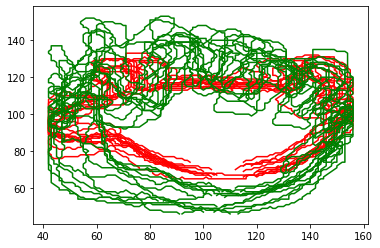

In [25]:
from functools import partial

db2 = db.copy()
db2.image = db2.image.apply(regularize)
db2.image = db2.image.apply(partial(regularize_scale, object_size=115, output_size=200))
for image in db2.query("clas=='turtle'").image:
    cmax = get_largest_contour(255-image)
    plt.plot([c[0,0] for c in cmax], [c[0,1] for c in cmax], color="r")

for image in db2.query("clas=='elephant'").image:
    cmax = get_largest_contour(255-image)
    plt.plot([c[0,0] for c in cmax], [c[0,1] for c in cmax], color="g")

In [26]:
db.image = db.image.apply(regularize)
db.image = db.image.apply(partial(regularize_scale, object_size=115, output_size=200))

In [46]:
def mask(image):
    return (image==0).flatten()

def hamming(desc, C):
    return np.sum(desc ^ C, axis=1)

In [47]:
queries, results = test_queries(mask, hamming, top_n=5)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


results:


Accuracies:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
Accuracy,,,,,,,,,,,,,,,,,,
0,0.8,1.0,1.0,1.0,1.0,1.0,1.0,0.2,0.2,1.0,1.0,1.0,1.0,0.4,1.0,1.0,1.0,1.0


Average along classes: 0.87


In [54]:
import skimage

(2916,)


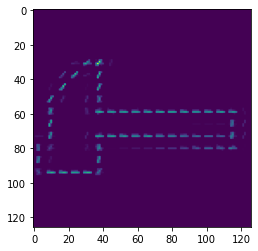

In [145]:
im = db.query("clas=='hammer'").image.iloc[7]


p = (200-125)//2
fd, hog_image = skimage.feature.hog(im[p:-p,p:-p], orientations=9, pixels_per_cell=(7,7),cells_per_block=(1,1), visualize=True)

print(fd.shape)
plt.imshow(hog_image)

def hog_desc(im):
    p = (200-125)//2
    im_f = cv2.blur(im,(9,9))
    fd, hog_image = skimage.feature.hog(im_f[p:-p,p:-p], orientations=9, pixels_per_cell=(7,7),cells_per_block=(1,1), visualize=True)
    return fd

In [147]:
queries, results = test_queries(hog_desc, cosine_distance, top_n=12)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


results:


Accuracies:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
Accuracy,,,,,,,,,,,,,,,,,,
0,0.666667,0.833333,1.0,0.666667,0.833333,1.0,1.0,0.166667,1.0,1.0,1.0,1.0,0.916667,0.166667,0.75,1.0,1.0,1.0


Average along classes: 0.83
